In [1]:
%load_ext pycodestyle_magic

In [21]:
#%%pycodestyle
# analyze_cooccurrency_themepark.py

import spacy
import pandas as pd

# 使用する単語の品詞とストップワードの指定
include_pos = ('NOUN', 'VERB', 'ADJ', 'PROPN')
stopwords = ('する', 'ある', 'ない', 'いう', 'もの', 'こと', 'よう',
             'なる', 'ほう', 'いる', 'くる', 'お', 'つ', 'おる', 'とき', 'しまう',
             'いく', 'みる', 'ため', 'ところ', '際', '他', '時', '中', '方', '回', '目', '年', '月', '日', '事'
             '思う', '行く', '行なう', '来る', '思う', '見る', '見える', '観る', '訪れる')

# 東京ディズニーランドの口コミのファイルの読み込み
df = pd.read_csv('text/tds.csv', encoding='utf-8',
                 parse_dates=['旅行の時期'])

# 空行を削除
df['口コミ'] = df['口コミ'].replace( '\n+', '\n', regex=True)

# 旅行の時期が欠損している口コミを削除する
df = df.dropna(subset=['旅行の時期'])

# 旅行の時期を年度に直し，「年度」という項目を追加
df['年度'] = df['旅行の時期'].apply(lambda x: x.year if x.month >= 4 else x.year-1)

# 旅行の時期を指定　ここでは2016年度から2018年度とする
from_year = 2016
to_year = 2018
df = df[(df['年度'] >= from_year) & (df['年度'] <= to_year)]

print(len(df))

nlp = spacy.load("ja_ginza")

645


In [15]:
def extract_words(sent, pos_tags, stopwords):
    words = [token.lemma_ for token in sent
             if token.pos_ in pos_tags and token.lemma_ not in stopwords]
    return words

In [16]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

def count_cooccurrence(tokens):    
    count_model = CountVectorizer(ngram_range=(1,1), token_pattern=u'(?u)\\b\\w+\\b') # default unigram model
    X = count_model.fit_transform(tokens)
    words = count_model.get_feature_names()
    word_counts = np.asarray(X.sum(axis=0)).reshape(-1)

    X[X > 0] = 1 # limit to 1 occurrence in a document.
    Xc = (X.T * X) # this is co-occurrence matrix in sparse csr format
    return words, word_counts, Xc, X

In [17]:
# visualize-2から cutoff = 0.03 * Xc_maxの0.03の値を引数をして渡すように変更

def word_weights(words, word_counts):
    count_max = word_counts.max()
    weights = [(word, {'weight': count / count_max})
               for word, count in zip(words, word_counts)]
    return weights

def cooccurrence_weights(words, Xc, weight_cutoff):
    Xc_max = Xc.max()
    cutoff = weight_cutoff * Xc_max
    weights = [(words[i], words[j], Xc[i,j] / Xc_max)
               for i, j in zip(*Xc.nonzero()) if i < j and Xc[i,j] > cutoff]
    return weights

In [18]:
import networkx as nx
from pyvis.network import Network
import matplotlib.pyplot as plt
import japanize_matplotlib

# visualize-2から,引数としてweight_cutoffを渡すように変更
def create_network(words, word_counts, Xc, weight_cutoff):
    G = nx.Graph()
    
    weights_w = word_weights(words, word_counts)
    G.add_nodes_from(weights_w)
    
    weights_c = cooccurrence_weights(words, Xc, weight_cutoff)
    G.add_weighted_edges_from(weights_c)
    
    G.remove_nodes_from(list(nx.isolates(G)))
    return G

def pyplot_network(G):
    plt.figure(figsize=(10, 10))
    pos = nx.spring_layout(G, k=0.1)

    weights_n = np.array(list(nx.get_node_attributes(G, 'weight').values()))
    nx.draw_networkx_nodes(G, pos, node_size=300 * weights_n)
        
    weights_e = np.array(list(nx.get_edge_attributes(G, 'weight').values()))
    nx.draw_networkx_edges(G, pos, width=20 * weights_e)
    
    nx.draw_networkx_labels(G, pos, font_family='IPAexGothic')

    plt.axis("off")
    plt.show()

def nx2pyvis_G(G):
    pyvis_G = Network(width='800px', height='800px', notebook=True)
    # pyvis_G.from_nx(G) # pyvisライブラリ現状では，属性が反映されない．
    for node, attrs in G.nodes(data=True):
        pyvis_G.add_node(node, title=node, size=30 * attrs['weight'])
    for node1, node2, attrs in G.edges(data=True):
        pyvis_G.add_edge(node1, node2, width=20 * attrs['weight'])
    return pyvis_G

In [19]:
# visualize-2から文のリストへの追加方法を変更
sents = []
for doc in nlp.pipe(df["口コミ"]):
    sents.extend([' '.join(extract_words(sent, include_pos, stopwords))
                  for sent in doc.sents])

words, word_counts, Xc, X = count_cooccurrence(sents)

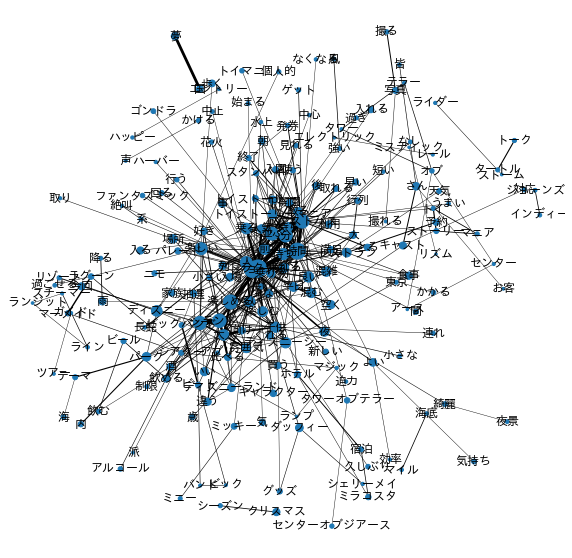

In [20]:
weight_cutoff = 0.020
G = create_network(words, word_counts, Xc, weight_cutoff)
pyplot_network(G)
pyvis_G = nx2pyvis_G(G)
pyvis_G.show("mygraph_tds.html")